In [31]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import optuna
import pickle


In [17]:
xgboost_validation_path = "D:/personal-projects/Nextock/xgboost_validations"
arima_validation_path = "D:/personal-projects/Nextock/arima_validations"

In [18]:
def load_validations(validation_path, model_type):
    validations = {}
    for file in os.listdir(validation_path):
        if file.endswith(f"_{model_type}_validation.csv"):
            ticker = file.split("_")[0]
            df = pd.read_csv(os.path.join(validation_path, file))
            validations[ticker] = df.iloc[0]  
    return pd.DataFrame.from_dict(validations, orient="index")

In [19]:
df_xgb_validations = load_validations(xgboost_validation_path, "xgboost")
df_arima_validations = load_validations(arima_validation_path, "Close")

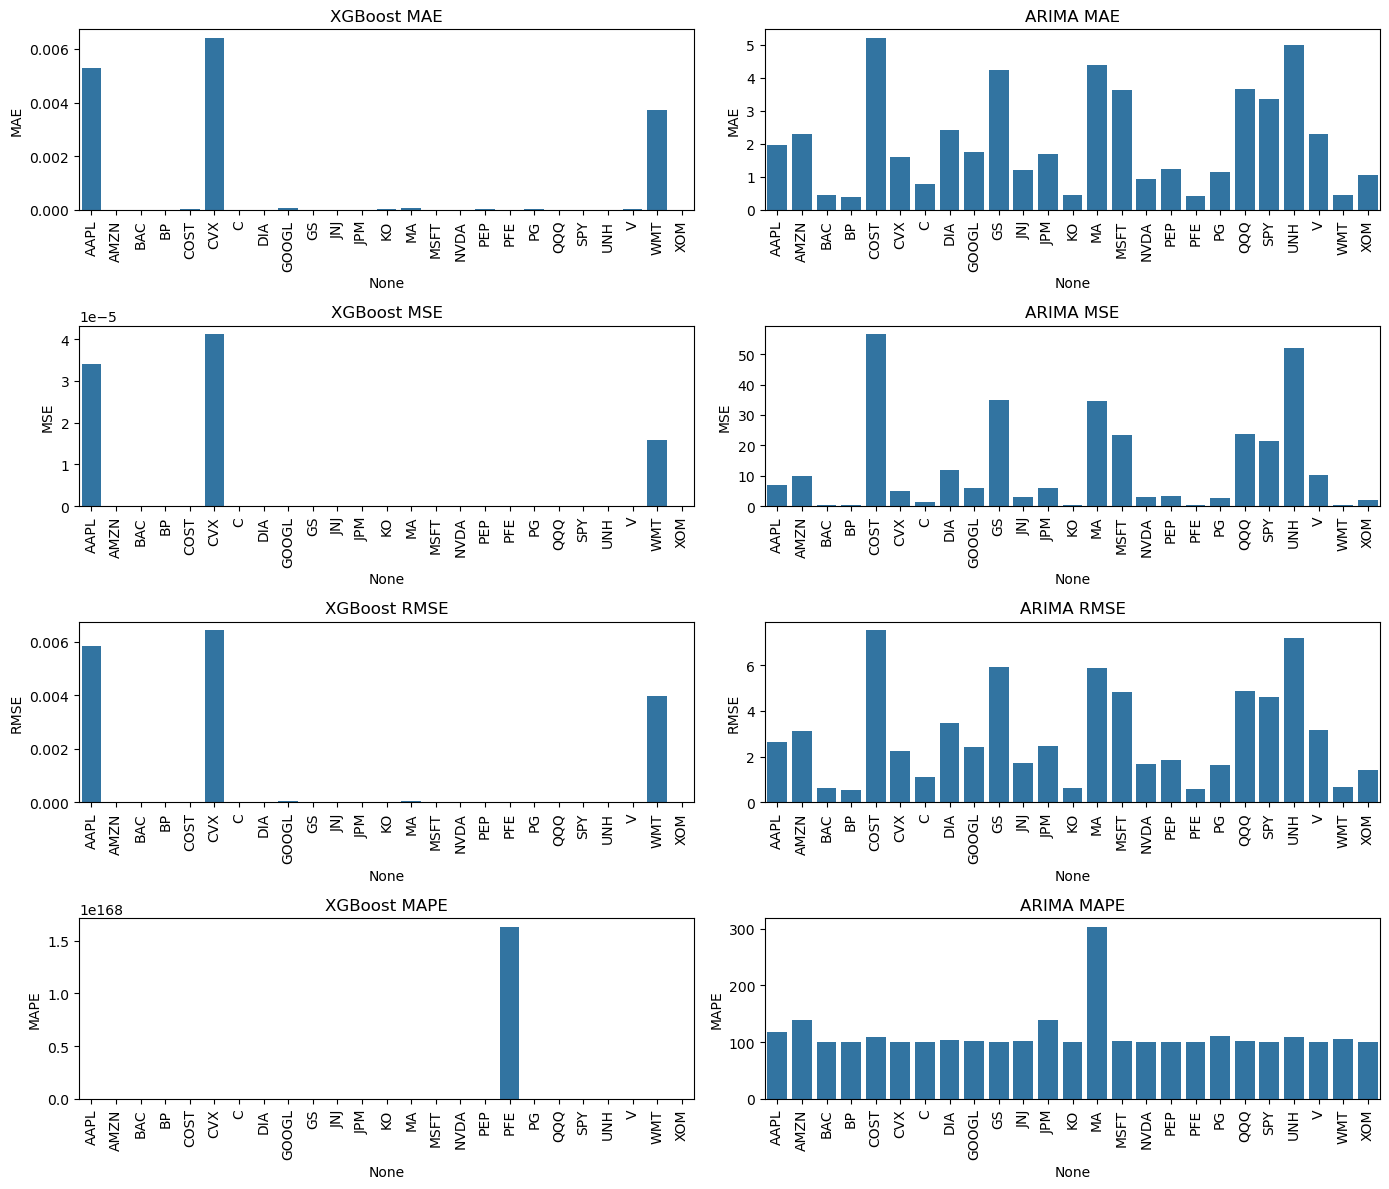

In [21]:
metrics = ["MAE", "MSE", "RMSE", "MAPE"]
fig, axes = plt.subplots(len(metrics), 2, figsize=(14, 12))

for i, metric in enumerate(metrics):
    sns.barplot(x=df_xgb_validations.index, y=df_xgb_validations[metric], ax=axes[i, 0])
    axes[i, 0].set_title(f"XGBoost {metric}")
    axes[i, 0].tick_params(axis='x', rotation=90)

    sns.barplot(x=df_arima_validations.index, y=df_arima_validations[metric], ax=axes[i, 1])
    axes[i, 1].set_title(f"ARIMA {metric}")
    axes[i, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [22]:
def detect_outliers(df, metric):
    Q1 = df[metric].quantile(0.25)
    Q3 = df[metric].quantile(0.75)
    IQR = Q3 - Q1
    threshold = 1.5 * IQR
    return df[(df[metric] > Q3 + threshold)]

In [26]:
outliers_xgb = {metric: detect_outliers(df_xgb_validations, metric) for metric in metrics}
outliers_arima = {metric: detect_outliers(df_arima_validations, metric) for metric in metrics}

In [27]:
for metric in metrics:
    print(f"XGBoost Outliers in {metric}:", outliers_xgb[metric].index.tolist())
    print(f"ARIMA Outliers in {metric}:", outliers_arima[metric].index.tolist())

XGBoost Outliers in MAE: ['AAPL', 'CVX', 'WMT']
ARIMA Outliers in MAE: []
XGBoost Outliers in MSE: ['AAPL', 'CVX', 'GOOGL', 'MA', 'WMT']
ARIMA Outliers in MSE: ['COST', 'UNH']
XGBoost Outliers in RMSE: ['AAPL', 'CVX', 'WMT']
ARIMA Outliers in RMSE: []
XGBoost Outliers in MAPE: ['BAC', 'BP', 'CVX', 'C', 'NVDA', 'PFE']
ARIMA Outliers in MAPE: ['AMZN', 'JPM', 'MA']


In [28]:
predictions_path = r"D:\personal-projects\Nextock\xgboost_predictions"
validation_path = r"D:\personal-projects\Nextock\xgboost_validations"
data_path = r"D:\personal-projects\Nextock\preprocessed_data"

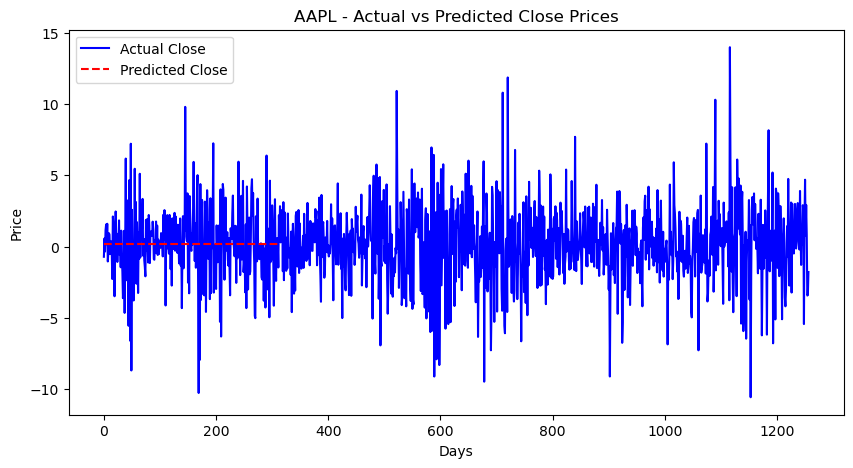

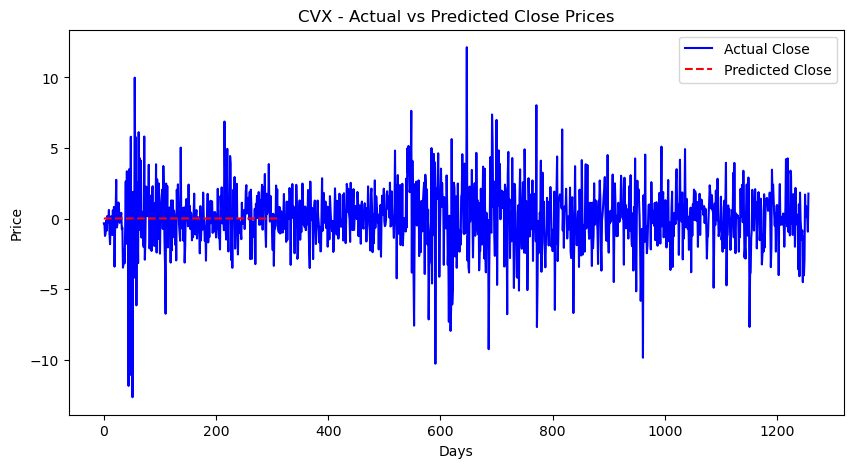

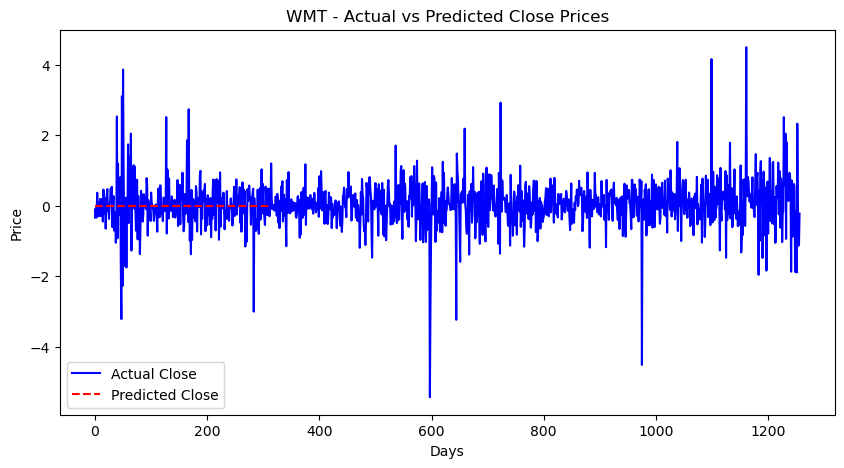

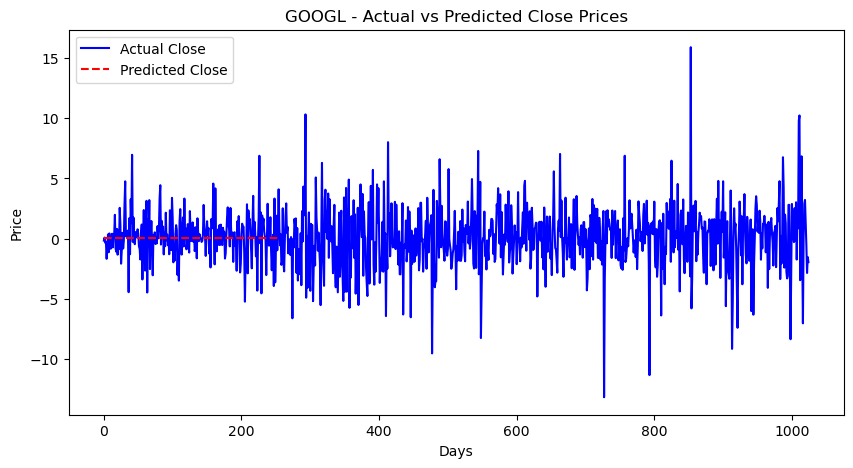

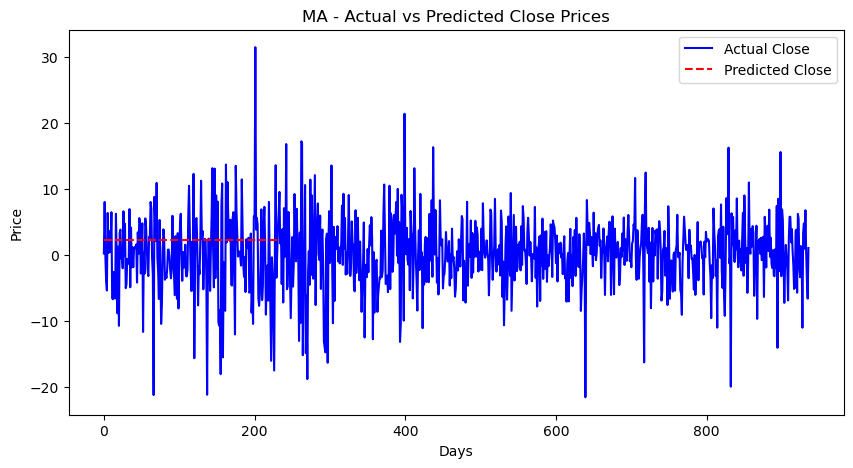

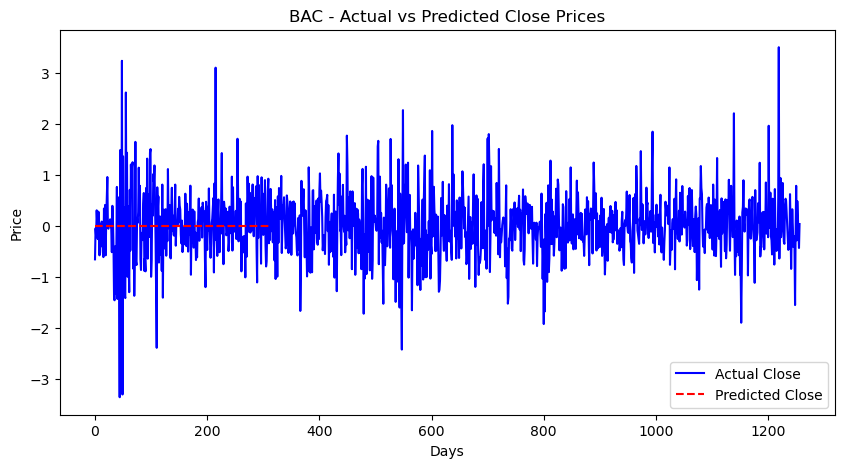

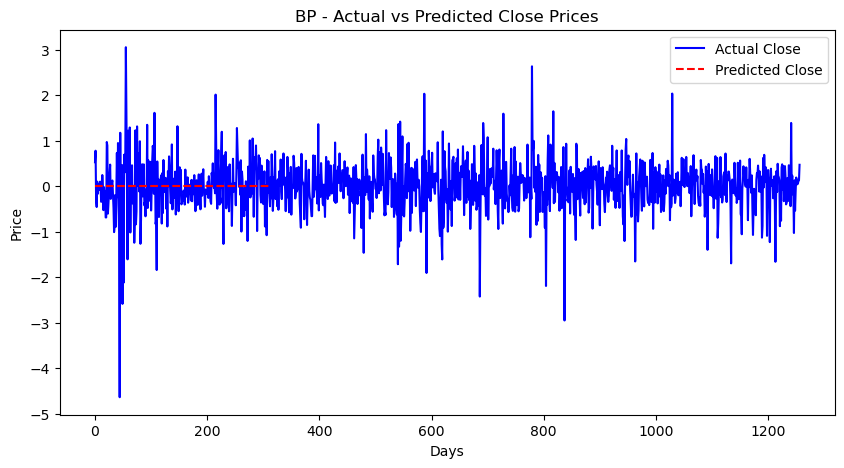

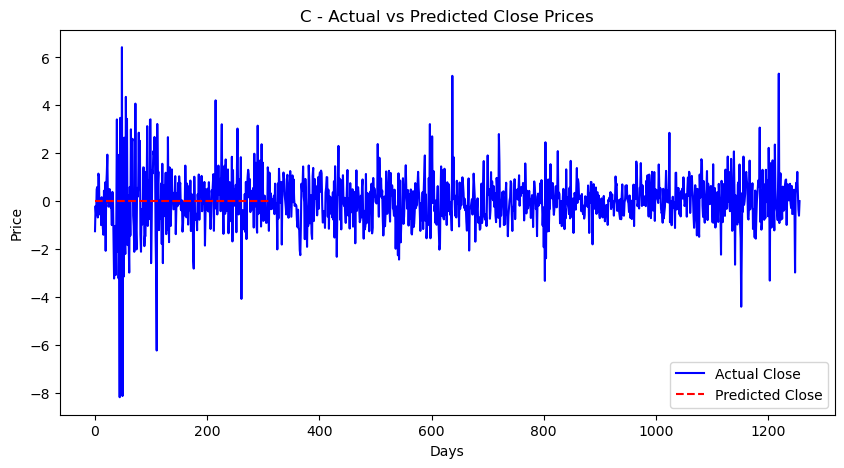

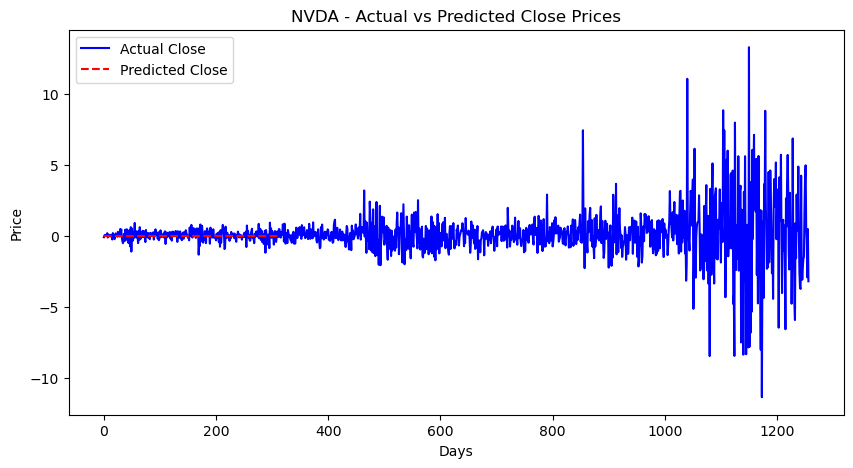

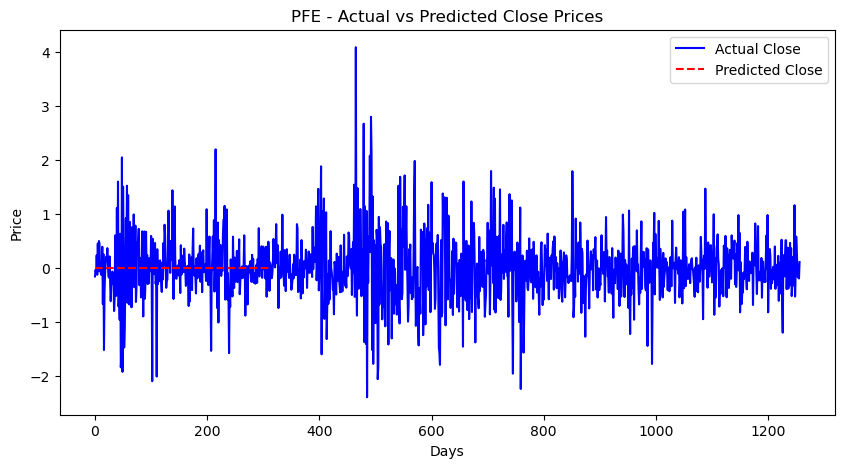

In [29]:
buggy_tickers = ['AAPL', 'CVX', 'WMT', 'GOOGL', 'MA', 'BAC', 'BP', 'C', 'NVDA', 'PFE']

for ticker in buggy_tickers:
    try:
        actual_data = pd.read_csv(os.path.join(data_path, f"{ticker}.csv"))
        actual_data = actual_data.tail(len(actual_data) // 5)  # Last 20% for test set

        predicted_data = pd.read_csv(os.path.join(predictions_path, f"{ticker}__xgboost_predictions.csv"))

        plt.figure(figsize=(10, 5))
        plt.plot(actual_data["Close"].values, label="Actual Close", color='blue')
        plt.plot(predicted_data["Predictions"].values, label="Predicted Close", linestyle="dashed", color='red')
        plt.title(f"{ticker} - Actual vs Predicted Close Prices")
        plt.xlabel("Days")
        plt.ylabel("Price")
        plt.legend()
        plt.show()
    
    except Exception as e:
        print(f"Error processing {ticker}: {e}")


In [30]:
for ticker in buggy_tickers:
    try:
        validation_file = os.path.join(validation_path, f"{ticker}_xgboost_validation.csv")
        df_validation = pd.read_csv(validation_file)
        print(f"Validation Metrics for {ticker}:")
        print(df_validation)
        print("\n" + "-"*50 + "\n")
    except Exception as e:
        print(f"Error loading validation for {ticker}: {e}")

🔹 Validation Metrics for AAPL:
       MAE       MSE      RMSE      MAPE
0  0.00529  0.000034  0.005825  2.397662

--------------------------------------------------

🔹 Validation Metrics for CVX:
        MAE       MSE      RMSE          MAPE
0  0.006407  0.000041  0.006417  3.619950e+24

--------------------------------------------------

🔹 Validation Metrics for WMT:
        MAE       MSE      RMSE       MAPE
0  0.003726  0.000016  0.003979  96.420262

--------------------------------------------------

🔹 Validation Metrics for GOOGL:
        MAE           MSE      RMSE     MAPE
0  0.000068  4.612927e-09  0.000068  0.31999

--------------------------------------------------

🔹 Validation Metrics for MA:
        MAE           MSE      RMSE      MAPE
0  0.000071  5.071304e-09  0.000071  0.003109

--------------------------------------------------

🔹 Validation Metrics for BAC:
        MAE           MSE      RMSE          MAPE
0  0.000008  6.036434e-11  0.000008  4.062706e+71

----------

In [32]:
def retrain_xgboost(ticker):
    print(f"Retraining XGBoost for {ticker}...")
    df = pd.read_csv(os.path.join(data_path, f"{ticker}.csv"))
    df = df.dropna()

    X = df[["Open", "High", "Low", "Volume"]].values
    y = df["Close"].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=False)

    model = xgb.XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6, 
        subsample=0.8, colsample_bytree=0.8, tree_method="gpu_hist"
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test != 0, y_test, 1))) * 100

    model_filename = os.path.join(r"D:\personal-projects\Nextock\xgboost_models", f"{ticker}_xgboost.pkl")
    with open(model_filename, "wb") as f:
        pickle.dump(model, f)
    
    predictions_filename = os.path.join(predictions_path, f"{ticker}__xgboost_predictions.csv")
    pd.DataFrame(y_pred, columns=["Predictions"]).to_csv(predictions_filename, index=False)

    validation_filename = os.path.join(validation_path, f"{ticker}_xgboost_validation.csv")
    pd.DataFrame([{"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape}]).to_csv(validation_filename, index=False)

    print(f"Retrained {ticker}, saved new predictions and validations.")

for ticker in buggy_tickers:
    retrain_xgboost(ticker)

Retraining XGBoost for AAPL...


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:05] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:06] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:06] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower perform

Retrained AAPL, saved new predictions and validations.
Retraining XGBoost for CVX...


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:08] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:08] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




Retrained CVX, saved new predictions and validations.
Retraining XGBoost for WMT...


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:09] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:09] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




Retrained WMT, saved new predictions and validations.
Retraining XGBoost for GOOGL...


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:10] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:10] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




Retrained GOOGL, saved new predictions and validations.
Retraining XGBoost for MA...


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:11] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:11] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




Retrained MA, saved new predictions and validations.
Retraining XGBoost for BAC...


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:13] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:13] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




Retrained BAC, saved new predictions and validations.
Retraining XGBoost for BP...


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:14] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:15] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




Retrained BP, saved new predictions and validations.
Retraining XGBoost for C...


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:16] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:16] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




Retrained C, saved new predictions and validations.
Retraining XGBoost for NVDA...


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:18] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:18] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




Retrained NVDA, saved new predictions and validations.
Retraining XGBoost for PFE...
Retrained PFE, saved new predictions and validations.


c:\Users\Uday\miniconda3\envs\finance\Lib\site-packages\xgboost\core.py:158: UserWarning:

[11:06:19] WARNING: D:\bld\xgboost-split_1738880170463\work\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




In [34]:
print("New Validation Scores After Retraining:")
for ticker in buggy_tickers:
    try:
        validation_file = os.path.join(validation_path, f"{ticker}_xgboost_validation.csv")
        df_validation = pd.read_csv(validation_file)
        print(ticker)
        print(df_validation)
        print("\n" + "-"*50 + "\n")
    except Exception as e:
        print(f"Error loading validation for {ticker}: {e}")


New Validation Scores After Retraining:
AAPL
        MAE       MSE      RMSE       MAPE
0  1.447381  4.199552  2.049281  155.89179

--------------------------------------------------

CVX
        MAE       MSE      RMSE        MAPE
0  0.913032  1.873575  1.368786  155.989654

--------------------------------------------------

WMT
        MAE       MSE      RMSE        MAPE
0  0.266309  0.182747  0.427489  190.572371

--------------------------------------------------

GOOGL
       MAE       MSE     RMSE        MAPE
0  1.02069  2.251769  1.50059  203.171242

--------------------------------------------------

MA
        MAE        MSE      RMSE        MAPE
0  2.343672  10.171791  3.189324  191.418762

--------------------------------------------------

BAC
        MAE       MSE      RMSE        MAPE
0  0.240619  0.115169  0.339365  140.020014

--------------------------------------------------

BP
        MAE       MSE      RMSE       MAPE
0  0.173838  0.067559  0.259921  98.794414

--

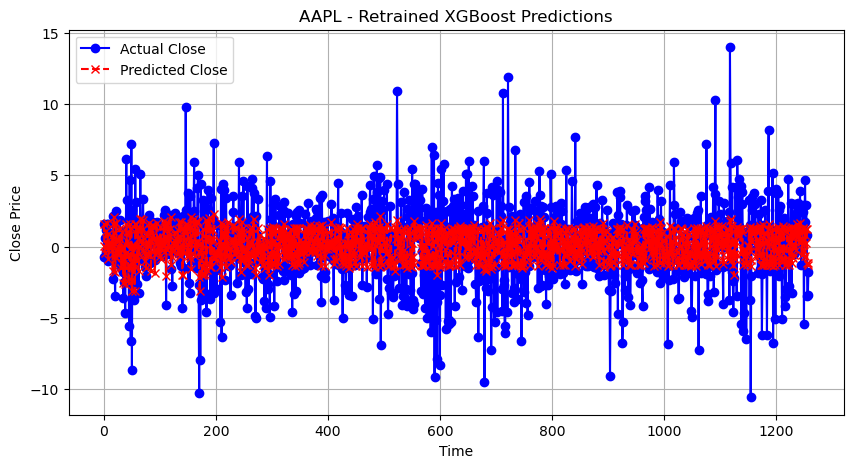

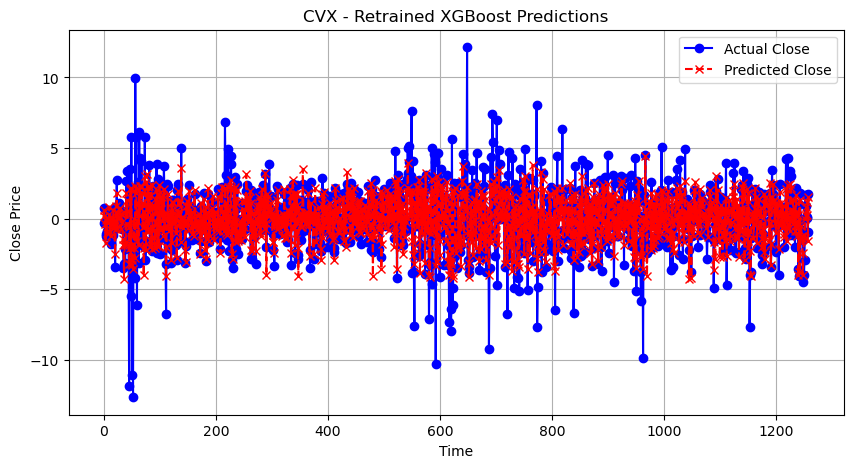

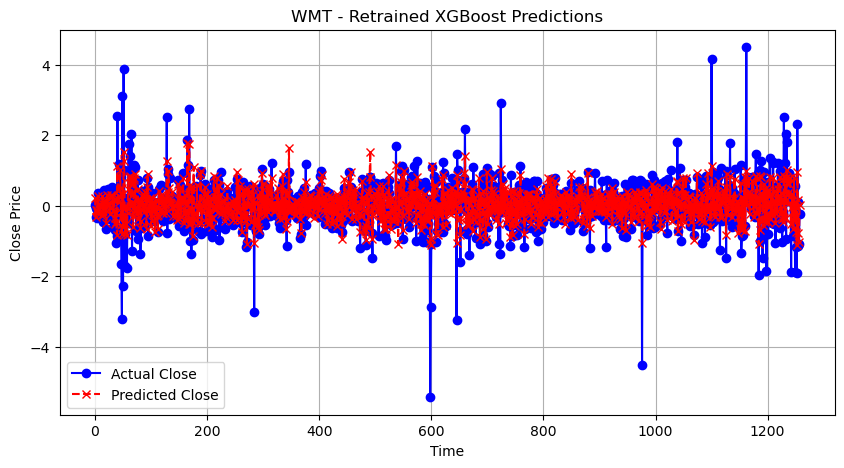

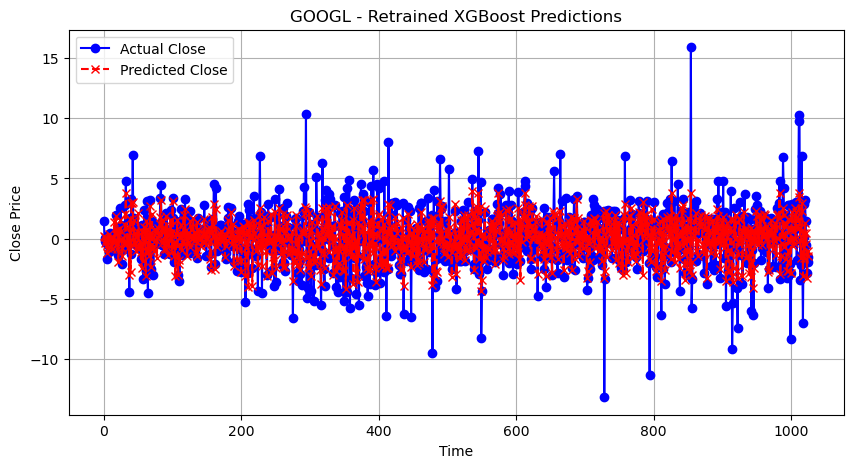

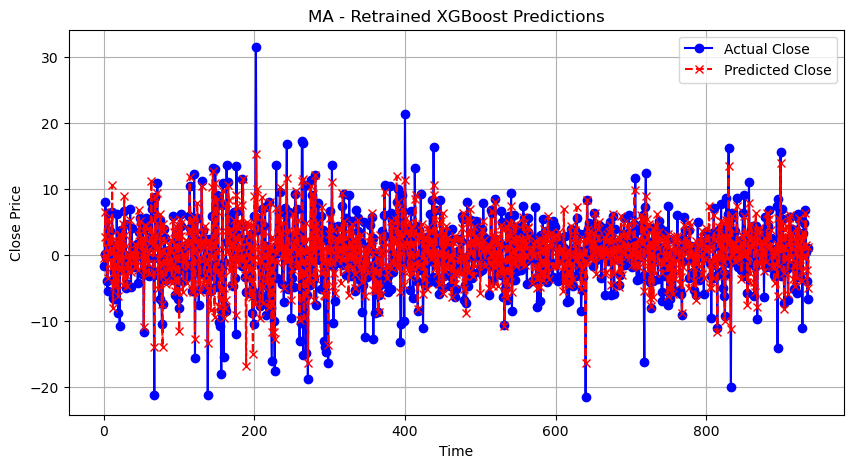

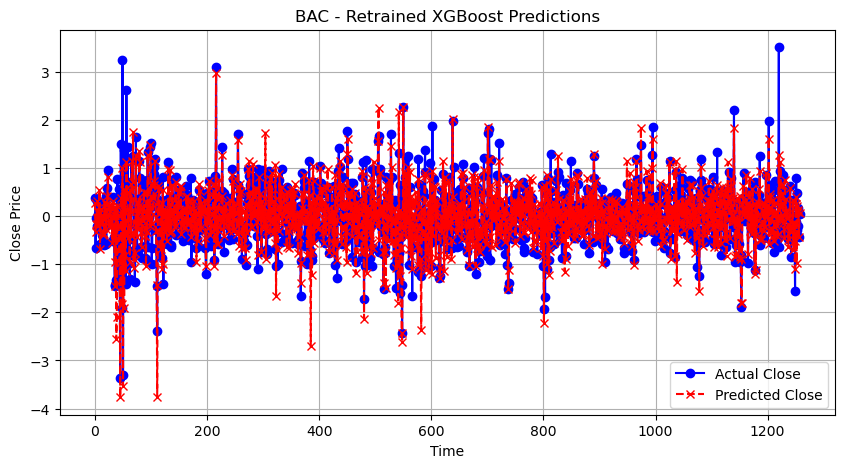

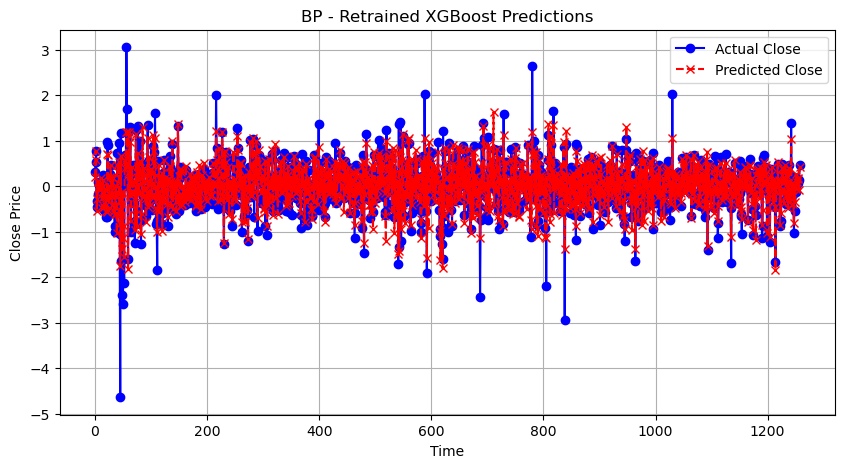

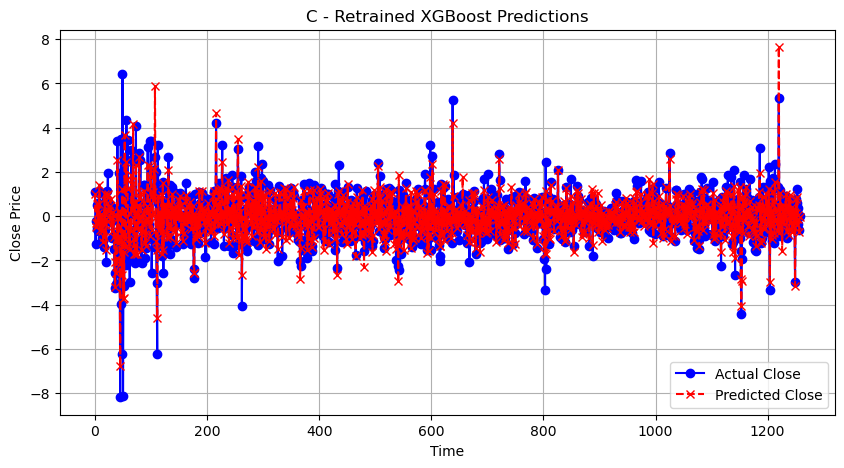

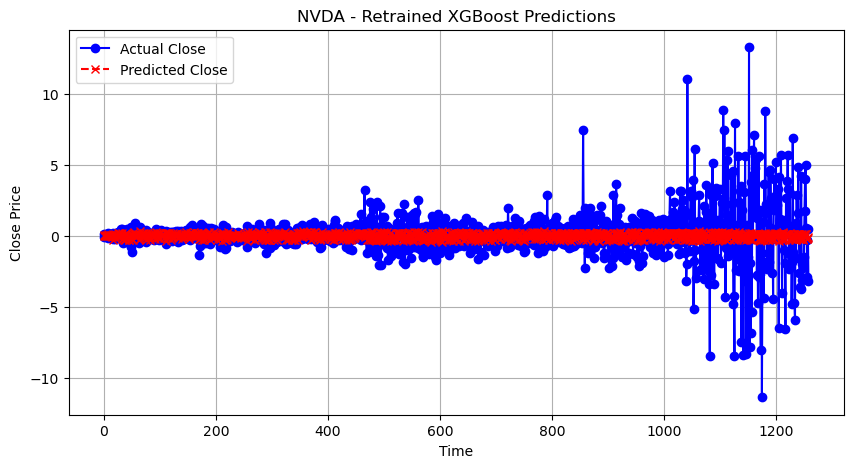

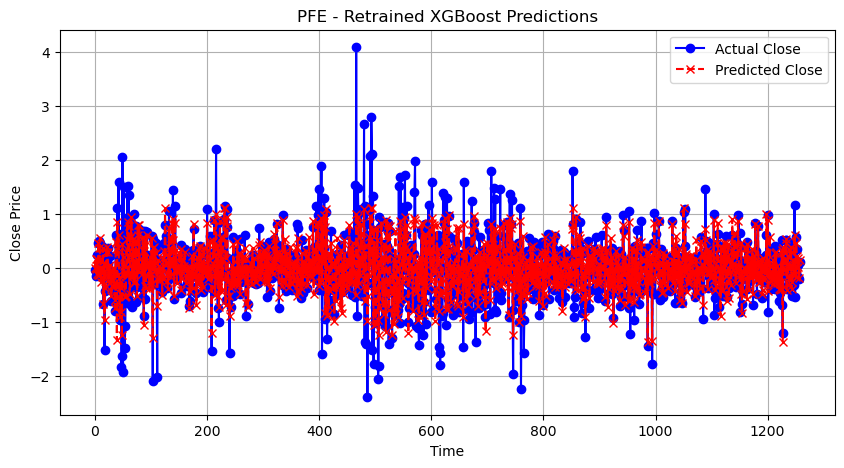

In [38]:
for ticker in buggy_tickers:
    pred_file = os.path.join(predictions_path, f"{ticker}__xgboost_predictions.csv")
    test_file = os.path.join(data_path, f"{ticker}.csv")

    if os.path.exists(pred_file) and os.path.exists(test_file):
        df_pred = pd.read_csv(pred_file)
        df_actual = pd.read_csv(test_file)

        if "Close" in df_actual.columns:
            y_actual = df_actual["Close"].iloc[-len(df_pred):].values
            y_pred = df_pred["Predictions"].values

            plt.figure(figsize=(10, 5))
            plt.plot(y_actual, label="Actual Close", marker="o", linestyle="-", color="blue")
            plt.plot(y_pred, label="Predicted Close", marker="x", linestyle="--", color="red")
            plt.title(f"{ticker} - Retrained XGBoost Predictions")
            plt.xlabel("Time")
            plt.ylabel("Close Price")
            plt.legend()
            plt.grid()
            plt.show()


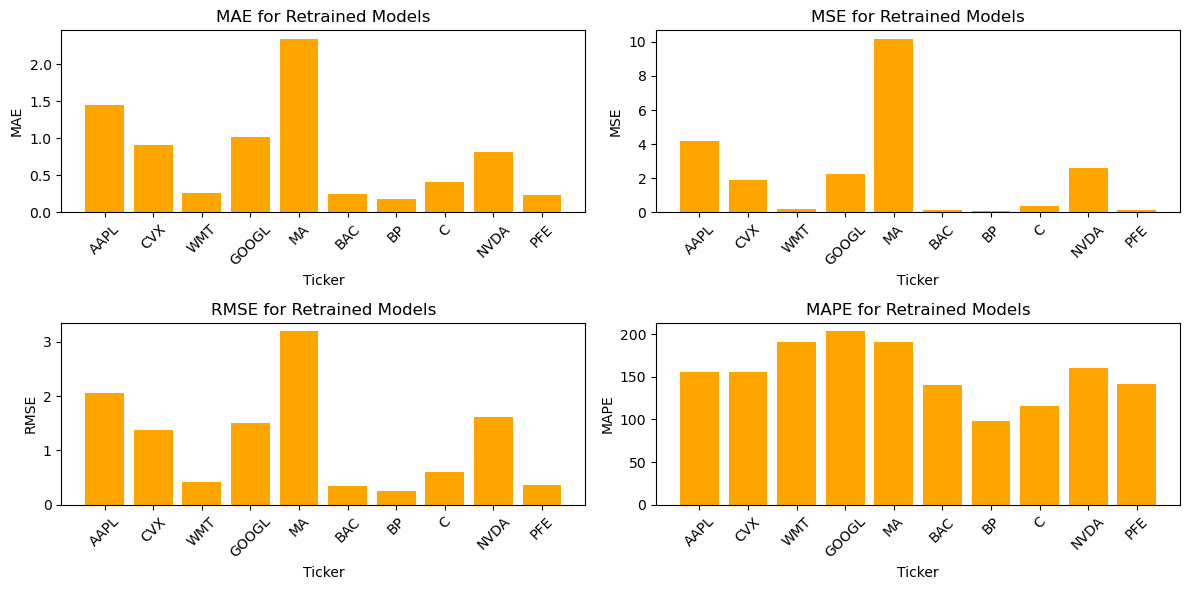

In [39]:
df_validations = []

for ticker in buggy_tickers:
    validation_file = os.path.join(validation_path, f"{ticker}_xgboost_validation.csv")
    if os.path.exists(validation_file):
        df_val = pd.read_csv(validation_file)
        df_val["Ticker"] = ticker
        df_validations.append(df_val)

if df_validations:
    df_validations = pd.concat(df_validations, ignore_index=True)
    
    plt.figure(figsize=(12, 6))
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        plt.bar(df_validations["Ticker"], df_validations[metric], color="orange")
        plt.xlabel("Ticker")
        plt.ylabel(metric)
        plt.title(f"{metric} for Retrained Models")
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()